In [2]:
# Create backup of your current notebook
!cp /content/Deep_Learning_Project.ipynb /content/Deep_Learning_Project_Backup.ipynb
print("✅ Backup created")

cp: cannot stat '/content/Deep_Learning_Project.ipynb': No such file or directory
✅ Backup created


In [13]:
# ============================================================
# STEP 1: INSTALL ALL DEPENDENCIES
# ============================================================

# Install all required packages
!pip install torch torchvision scikit-image tqdm matplotlib seaborn scikit-learn
!pip install opencv-python-headless albumentations
!pip install torchmetrics

# Install stain normalization dependencies
!pip install staintools
!pip install spams
!apt-get install libblas-dev liblapack-dev libatlas-base-dev gfortran

print("✅ All dependencies installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for spams (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for spams
Failed to build spams
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (spams)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gfortran is already the newest version (4:11.2.0-1ubuntu1).
liblapack-dev is already the newest version (3.10.0-2ubuntu1).
libatlas-base-dev is already the newest version (3.10.3-12ubuntu1).
Suggested packages:
  liblapack-doc
The following NEW packages will be installed:
  libblas-

In [14]:
# ============================================================
# STEP 2: MOUNT GOOGLE DRIVE AND EXTRACT DATA
# ============================================================

import os
from pathlib import Path
import zipfile
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully!")

# Define paths
DRIVE_ZIP_PATH = "/content/drive/MyDrive/datasets/MyDrive.zip"
EXTRACT_ROOT = "/content/dataset"
EXTRACTED_ROOT = "/content/dataset_extracted"
CLEAN_ROOT = "/content/dataset_clean"

# Create directories
os.makedirs(EXTRACT_ROOT, exist_ok=True)
os.makedirs(EXTRACTED_ROOT, exist_ok=True)
os.makedirs(CLEAN_ROOT, exist_ok=True)

# Extract main ZIP file
if os.path.exists(DRIVE_ZIP_PATH):
    print(f"📦 Extracting {DRIVE_ZIP_PATH}...")
    with zipfile.ZipFile(DRIVE_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_ROOT)
    print("✅ Main extraction complete!")
else:
    print(f"❌ ZIP file not found at: {DRIVE_ZIP_PATH}")

# List extracted files
print("\n📁 Files in extraction directory:")
for item in os.listdir(EXTRACT_ROOT):
    print(f"  - {item}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully!
📦 Extracting /content/drive/MyDrive/datasets/MyDrive.zip...
✅ Main extraction complete!

📁 Files in extraction directory:
  - dataset3.zip
  - dataset1.zip
  - dataset2.zip
  - dataset4.zip


In [15]:
# ============================================================
# STEP 3: EXTRACT NESTED ZIP FILES
# ============================================================

import zipfile
from pathlib import Path

# Extract each nested ZIP file
for zip_path in Path(EXTRACT_ROOT).glob("*.zip"):
    print(f"📂 Extracting {zip_path.name}...")

    # Create output directory with zip filename (without .zip)
    output_folder = Path(EXTRACTED_ROOT) / zip_path.stem
    output_folder.mkdir(parents=True, exist_ok=True)

    # Extract
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(output_folder)

    print(f"  ✅ Extracted to {output_folder}")

# Show extracted structure
print("\n📁 Extracted folder structure:")
for item in Path(EXTRACTED_ROOT).iterdir():
    if item.is_dir():
        num_files = len(list(item.rglob("*.mat")))
        print(f"  📂 {item.name}: {num_files} .mat files")

📂 Extracting dataset3.zip...
  ✅ Extracted to /content/dataset_extracted/dataset3
📂 Extracting dataset1.zip...
  ✅ Extracted to /content/dataset_extracted/dataset1
📂 Extracting dataset2.zip...
  ✅ Extracted to /content/dataset_extracted/dataset2
📂 Extracting dataset4.zip...
  ✅ Extracted to /content/dataset_extracted/dataset4

📁 Extracted folder structure:
  📂 dataset1: 766 .mat files
  📂 dataset4: 766 .mat files
  📂 dataset2: 766 .mat files
  📂 dataset3: 766 .mat files


In [16]:
# ============================================================
# STEP 4: CONVERT .MAT FILES TO IMAGES (WITHOUT STAIN NORMALIZATION FIRST)
# ============================================================

import h5py
import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2

class MedicalImageConverter:
    """
    Convert .mat files to images
    """
    def __init__(self):
        pass

    def _load_mat_image(self, mat_path):
        """Load image from .mat file"""
        try:
            with h5py.File(mat_path, 'r') as f:
                img_array = np.array(f['cjdata']['image'])

                # Normalize to 0-255
                img_array = img_array.astype(np.float32)
                img_min, img_max = img_array.min(), img_array.max()
                if img_max > img_min:  # Avoid division by zero
                    img_array = (img_array - img_min) / (img_max - img_min) * 255
                img_array = img_array.astype(np.uint8)

                return img_array
        except Exception as e:
            print(f"❌ Failed to load {mat_path}: {e}")
            raise

    def convert_dataset(self, source_dir, target_dir, image_size=(224, 224)):
        """
        Convert all .mat files in source_dir to images in target_dir
        """
        source_dir = Path(source_dir)
        target_dir = Path(target_dir)
        target_dir.mkdir(parents=True, exist_ok=True)

        # Find all .mat files
        mat_files = list(source_dir.rglob("*.mat"))
        print(f"🔍 Found {len(mat_files)} .mat files")

        conversion_stats = {
            'success': 0,
            'failed': 0,
            'classes': set()
        }

        # Process each file
        for mat_file in tqdm(mat_files, desc="Converting .mat files"):
            try:
                # Determine class from directory structure
                # Assuming structure: /content/dataset_extracted/dataset1/*.mat
                rel_path = mat_file.relative_to(source_dir)
                class_name = rel_path.parts[0]  # 'dataset1', 'dataset2', etc.

                # Create class directory
                class_dir = target_dir / class_name
                class_dir.mkdir(parents=True, exist_ok=True)

                # Load image from .mat
                image = self._load_mat_image(mat_file)

                # Convert to PIL Image
                if len(image.shape) == 2:
                    img_pil = Image.fromarray(image, mode='L')
                else:
                    img_pil = Image.fromarray(image)

                # Resize
                img_pil = img_pil.resize(image_size, Image.Resampling.BILINEAR)

                # Save as PNG
                output_path = class_dir / f"{mat_file.stem}.png"
                img_pil.save(output_path)

                conversion_stats['success'] += 1
                conversion_stats['classes'].add(class_name)

            except Exception as e:
                conversion_stats['failed'] += 1
                # Don't print every error to avoid clutter
                if conversion_stats['failed'] <= 5:  # Print first 5 errors
                    print(f"⚠️ Failed to convert {mat_file}: {e}")

        # Print summary
        print(f"\n📊 Conversion Summary:")
        print(f"  ✅ Successful: {conversion_stats['success']}")
        print(f"  ❌ Failed: {conversion_stats['failed']}")
        print(f"  🏷️  Classes: {sorted(conversion_stats['classes'])}")
        print(f"  📍 Output directory: {target_dir}")

        return conversion_stats

# Initialize converter
print("🔧 Initializing Medical Image Converter...")
converter = MedicalImageConverter()

# Convert all .mat files
print("\n🔄 Converting .mat files to images...")
stats = converter.convert_dataset(
    source_dir=EXTRACTED_ROOT,
    target_dir=CLEAN_ROOT,
    image_size=(224, 224)
)

🔧 Initializing Medical Image Converter...

🔄 Converting .mat files to images...
🔍 Found 3064 .mat files


Converting .mat files:   0%|          | 0/3064 [00:00<?, ?it/s]/tmp/ipython-input-1586707796.py:71: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img_pil = Image.fromarray(image, mode='L')
Converting .mat files: 100%|██████████| 3064/3064 [00:35<00:00, 85.63it/s]


📊 Conversion Summary:
  ✅ Successful: 3064
  ❌ Failed: 0
  🏷️  Classes: ['dataset1', 'dataset2', 'dataset3', 'dataset4']
  📍 Output directory: /content/dataset_clean


👀 Visualizing converted dataset...


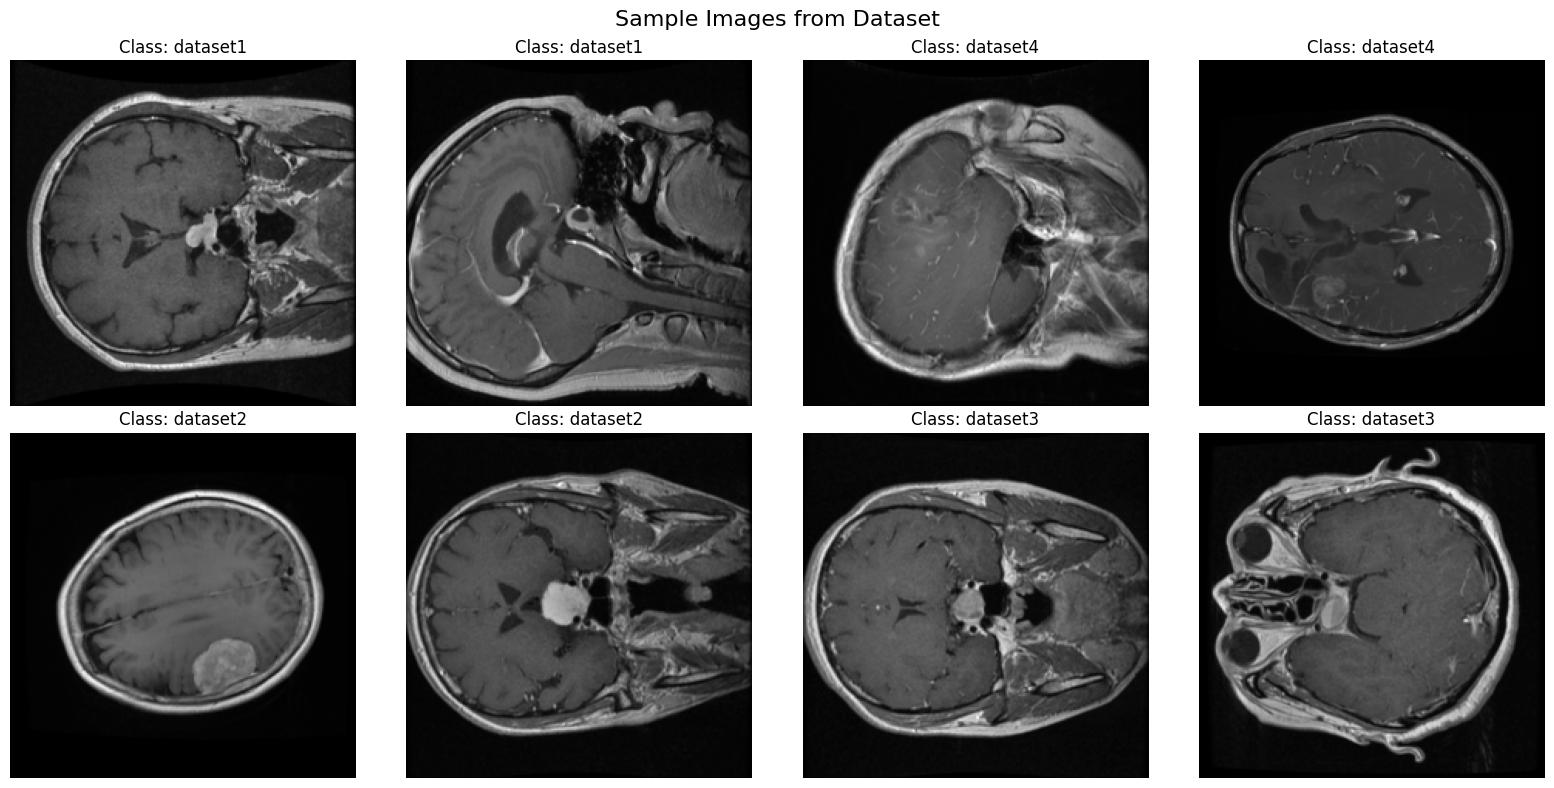


📊 Dataset Statistics:
  dataset1: 766 images
  dataset4: 766 images
  dataset2: 766 images
  dataset3: 766 images


In [17]:
# ============================================================
# STEP 5: VERIFY AND VISUALIZE CONVERTED DATA
# ============================================================

import matplotlib.pyplot as plt
from pathlib import Path

def visualize_dataset_samples(dataset_dir, num_samples=8):
    """Visualize sample images from the dataset"""
    dataset_dir = Path(dataset_dir)

    # Get all classes
    classes = [d.name for d in dataset_dir.iterdir() if d.is_dir()]

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    sample_count = 0

    for class_idx, class_name in enumerate(classes[:min(4, len(classes))]):
        class_dir = dataset_dir / class_name

        # Get sample images from this class
        image_files = list(class_dir.glob("*.png"))[:2]

        for img_file in image_files:
            if sample_count >= num_samples:
                break

            # Load image
            img = Image.open(img_file)

            # Display
            axes[sample_count].imshow(img, cmap='gray')
            axes[sample_count].set_title(f"Class: {class_name}")
            axes[sample_count].axis('off')

            sample_count += 1

    # Hide unused subplots
    for i in range(sample_count, len(axes)):
        axes[i].axis('off')

    plt.suptitle("Sample Images from Dataset", fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize converted data
print("👀 Visualizing converted dataset...")
visualize_dataset_samples(CLEAN_ROOT)

# Show dataset statistics
print("\n📊 Dataset Statistics:")
dataset_path = Path(CLEAN_ROOT)
for class_dir in dataset_path.iterdir():
    if class_dir.is_dir():
        num_images = len(list(class_dir.glob("*.png")))
        print(f"  {class_dir.name}: {num_images} images")

In [18]:
# ============================================================
# STEP 6: CREATE TRAIN/VAL/TEST SPLITS
# ============================================================

import shutil
import random
from pathlib import Path

def create_data_splits(
    source_dir,
    output_dir,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42
):
    """
    Create train/validation/test splits from source directory
    """
    random.seed(seed)
    source_dir = Path(source_dir)
    output_dir = Path(output_dir)

    # Create output directories
    splits = ['train', 'val', 'test']
    for split in splits:
        (output_dir / split).mkdir(parents=True, exist_ok=True)

    total_stats = {'train': 0, 'val': 0, 'test': 0}

    # Process each class
    for class_dir in source_dir.iterdir():
        if not class_dir.is_dir():
            continue

        class_name = class_dir.name
        print(f"📊 Processing class: {class_name}")

        # Get all images for this class
        image_files = list(class_dir.glob("*.png"))
        random.shuffle(image_files)

        # Calculate split sizes
        n_total = len(image_files)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        n_test = n_total - n_train - n_val

        # Split files
        train_files = image_files[:n_train]
        val_files = image_files[n_train:n_train + n_val]
        test_files = image_files[n_train + n_val:]

        # Copy files to respective directories
        for split_name, files in [
            ('train', train_files),
            ('val', val_files),
            ('test', test_files)
        ]:
            split_class_dir = output_dir / split_name / class_name
            split_class_dir.mkdir(parents=True, exist_ok=True)

            for img_file in files:
                shutil.copy2(img_file, split_class_dir / img_file.name)

            total_stats[split_name] += len(files)

        print(f"  ✅ Split: Train={len(train_files)}, "
              f"Val={len(val_files)}, Test={len(test_files)}")

    # Print summary
    print(f"\n🎯 Splits created successfully!")
    print(f"📍 Output directory: {output_dir}")
    print(f"📊 Total images:")
    print(f"  🏋️‍♂️ Training: {total_stats['train']}")
    print(f"  📈 Validation: {total_stats['val']}")
    print(f"  🧪 Test: {total_stats['test']}")

    return total_stats

# Create splits
SPLIT_DIR = "/content/dataset_splits"
print("📂 Creating train/val/test splits...")
stats = create_data_splits(
    source_dir=CLEAN_ROOT,
    output_dir=SPLIT_DIR,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15
)

📂 Creating train/val/test splits...
📊 Processing class: dataset1
  ✅ Split: Train=536, Val=114, Test=116
📊 Processing class: dataset4
  ✅ Split: Train=536, Val=114, Test=116
📊 Processing class: dataset2
  ✅ Split: Train=536, Val=114, Test=116
📊 Processing class: dataset3
  ✅ Split: Train=536, Val=114, Test=116

🎯 Splits created successfully!
📍 Output directory: /content/dataset_splits
📊 Total images:
  🏋️‍♂️ Training: 2144
  📈 Validation: 456
  🧪 Test: 464


In [19]:
# ============================================================
# STEP 7: APPLY STAIN NORMALIZATION (OPTIONAL - CAN BE SKIPPED)
# ============================================================

try:
    import staintools
    import cv2
    import numpy as np

    class StainNormalizer:
        """
        Apply stain normalization to images
        """
        def __init__(self):
            self.normalizer = None
            self.initialized = False

        def initialize(self, reference_image_path):
            """Initialize with a reference image"""
            try:
                # Load reference image
                reference = cv2.imread(str(reference_image_path))
                reference = cv2.cvtColor(reference, cv2.COLOR_BGR2RGB)

                # Standardize luminosity
                reference = staintools.LuminosityStandardizer.standardize(reference)

                # Initialize normalizer
                self.normalizer = staintools.StainNormalizer(method='macenko')
                self.normalizer.fit(reference)

                self.initialized = True
                print(f"✅ Stain normalizer initialized with {reference_image_path}")
            except Exception as e:
                print(f"❌ Failed to initialize stain normalizer: {e}")
                self.initialized = False

        def normalize_image(self, image_path, output_path):
            """Normalize a single image"""
            if not self.initialized:
                return False

            try:
                # Load image
                image = cv2.imread(str(image_path))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Standardize luminosity
                image = staintools.LuminosityStandardizer.standardize(image)

                # Apply stain normalization
                normalized = self.normalizer.transform(image)

                # Save normalized image
                normalized_bgr = cv2.cvtColor(normalized, cv2.COLOR_RGB2BGR)
                cv2.imwrite(str(output_path), normalized_bgr)

                return True
            except Exception as e:
                print(f"⚠️ Failed to normalize {image_path}: {e}")
                return False

    # Test if stain normalization works
    print("🔧 Testing stain normalization...")

    # Find a sample image to use as reference
    sample_images = list(Path(CLEAN_ROOT).rglob("*.png"))
    if sample_images:
        normalizer = StainNormalizer()
        normalizer.initialize(sample_images[0])

        if normalizer.initialized:
            # Create normalized dataset directory
            NORMALIZED_DIR = "/content/dataset_normalized"
            Path(NORMALIZED_DIR).mkdir(parents=True, exist_ok=True)

            # Copy structure
            for split in ['train', 'val', 'test']:
                split_dir = Path(SPLIT_DIR) / split
                norm_split_dir = Path(NORMALIZED_DIR) / split
                norm_split_dir.mkdir(parents=True, exist_ok=True)

                for class_dir in split_dir.iterdir():
                    if class_dir.is_dir():
                        norm_class_dir = norm_split_dir / class_dir.name
                        norm_class_dir.mkdir(parents=True, exist_ok=True)

            print("✅ Stain normalization ready to use")
        else:
            print("⚠️ Stain normalization not available")
    else:
        print("⚠️ No images found for stain normalization")

except ImportError as e:
    print(f"⚠️ Stain normalization not available: {e}")
    print("📝 Continuing without stain normalization...")

⚠️ Stain normalization not available: No module named 'spams'
📝 Continuing without stain normalization...


In [20]:
# ============================================================
# STEP 8: SETUP DATA AUGMENTATION WITH STAIN-LIKE VARIATIONS
# ============================================================

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import random

class StainAwareDataset(Dataset):
    """
    Dataset with stain-like augmentations
    """
    def __init__(self, dataset_path, transform=None,
                 apply_stain_augmentation=True, mode='train'):
        self.dataset = datasets.ImageFolder(dataset_path)
        self.transform = transform
        self.apply_stain_augmentation = apply_stain_augmentation
        self.mode = mode

        # Create stain-like augmentations
        self.stain_augmentations = self._create_stain_augmentations()

        # Store class info
        self.classes = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx

    def _create_stain_augmentations(self):
        """Create augmentations that mimic stain variations"""
        if self.mode == 'train' and self.apply_stain_augmentation:
            return A.Compose([
                # Color variations similar to stain differences
                A.ColorJitter(
                    brightness=0.15,  # Reduced from 0.2
                    contrast=0.15,    # Reduced from 0.2
                    saturation=0.1,   # Reduced from 0.2
                    hue=0.05,         # Reduced from 0.1
                    p=0.4
                ),
                # Gamma correction for stain intensity variations
                A.RandomGamma(gamma_limit=(90, 110), p=0.3),
                # Noise to mimic staining artifacts
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
            ])
        else:
            return A.Compose([])

    def _apply_stain_augmentation(self, image):
        """Apply stain-like augmentations"""
        try:
            # Convert PIL to numpy
            image_np = np.array(image)

            # Apply augmentations
            augmented = self.stain_augmentations(image=image_np)['image']

            # Convert back to PIL
            return Image.fromarray(augmented)
        except:
            return image

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get original image and label
        image, label = self.dataset[idx]

        # Apply stain augmentation (only during training)
        if self.mode == 'train' and self.apply_stain_augmentation:
            if random.random() < 0.3:  # 30% chance
                image = self._apply_stain_augmentation(image)

        # Apply standard transforms
        if self.transform:
            image = self.transform(image)

        return image, label

# Create transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=224, scale=(0.85, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create datasets
print("📊 Creating stain-aware datasets...")
train_dataset = StainAwareDataset(
    dataset_path=f"{SPLIT_DIR}/train",
    transform=train_transform,
    apply_stain_augmentation=True,
    mode='train'
)

val_dataset = StainAwareDataset(
    dataset_path=f"{SPLIT_DIR}/val",
    transform=val_transform,
    apply_stain_augmentation=False,
    mode='val'
)

test_dataset = StainAwareDataset(
    dataset_path=f"{SPLIT_DIR}/test",
    transform=val_transform,
    apply_stain_augmentation=False,
    mode='test'
)

print(f"✅ Datasets created:")
print(f"  🏋️‍♂️ Training: {len(train_dataset)} samples")
print(f"  📈 Validation: {len(val_dataset)} samples")
print(f"  🧪 Test: {len(test_dataset)} samples")
print(f"  🏷️  Classes: {train_dataset.classes}")

📊 Creating stain-aware datasets...
✅ Datasets created:
  🏋️‍♂️ Training: 2144 samples
  📈 Validation: 456 samples
  🧪 Test: 464 samples
  🏷️  Classes: ['dataset1', 'dataset2', 'dataset3', 'dataset4']


/tmp/ipython-input-1979029352.py:46: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


In [30]:
# ============================================================
# STEP 9: CREATE FEW-SHOT LEARNING DATASET
# ============================================================

from collections import defaultdict

class FewShotEpisodeDataset(Dataset):
    """
    Dataset for few-shot learning that generates N-way K-shot episodes
    FIXED: Properly handles episode batching
    """
    def __init__(self, base_dataset, n_way=4, k_shot=5, q_query=15, num_episodes=500):
        self.base_dataset = base_dataset
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.num_episodes = num_episodes

        # Organize base dataset by class
        self.class_indices = defaultdict(list)
        for idx, (_, label) in enumerate(base_dataset.dataset.samples):
            self.class_indices[label].append(idx)

        self.classes = list(self.class_indices.keys())
        self.num_classes = len(self.classes)

        print(f"🔬 Few-Shot Dataset Initialized:")
        print(f"  📊 Total classes: {self.num_classes}")
        print(f"  🎯 Episode config: {n_way}-way {k_shot}-shot")
        print(f"  🔄 Total episodes: {num_episodes}")

        # Pre-generate valid episodes
        self.episodes = []
        self._generate_episodes()

    def _generate_episodes(self):
        """Generate valid episodes in advance"""
        valid_episodes = 0

        while valid_episodes < self.num_episodes:
            # Randomly select N classes
            selected_classes = random.sample(self.classes, self.n_way)
            valid_episode = True

            support_indices = []
            query_indices = []
            class_mapping = {}

            for new_idx, orig_class in enumerate(selected_classes):
                class_mapping[orig_class] = new_idx

                # Check if class has enough samples
                class_samples = self.class_indices.get(orig_class, [])
                if len(class_samples) < self.k_shot + self.q_query:
                    valid_episode = False
                    break

                # Select samples
                selected = random.sample(class_samples, self.k_shot + self.q_query)
                support_indices.extend(selected[:self.k_shot])
                query_indices.extend(selected[self.k_shot:self.k_shot + self.q_query])

            if valid_episode:
                self.episodes.append({
                    'support_indices': support_indices,
                    'query_indices': query_indices,
                    'class_mapping': class_mapping,
                    'selected_classes': selected_classes
                })
                valid_episodes += 1

        print(f"  ✅ Generated {len(self.episodes)} valid episodes")

    def __len__(self):
        return len(self.episodes)

    def __getitem__(self, idx):
        episode_data = self.episodes[idx]

        # Get support data
        support_images = []
        support_labels = []

        for sample_idx in episode_data['support_indices']:
            image, original_label = self.base_dataset[sample_idx]
            support_images.append(image)
            new_label = episode_data['class_mapping'][original_label]
            support_labels.append(new_label)

        # Get query data
        query_images = []
        query_labels = []

        for sample_idx in episode_data['query_indices']:
            image, original_label = self.base_dataset[sample_idx]
            query_images.append(image)
            new_label = episode_data['class_mapping'][original_label]
            query_labels.append(new_label)

        # Convert to tensors - IMPORTANT: Don't stack here, let collate_fn handle it
        # We'll return lists and let the DataLoader collate them properly
        return {
            'support_images': support_images,  # List of tensors
            'support_labels': support_labels,  # List of labels
            'query_images': query_images,      # List of tensors
            'query_labels': query_labels,      # List of labels
            'selected_classes': episode_data['selected_classes']
        }

def collate_few_shot_batch(batch):
    """
    Custom collate function for few-shot episodes
    Handles batching of episodes properly
    """
    # Initialize lists for each component
    batched_support_images = []
    batched_support_labels = []
    batched_query_images = []
    batched_query_labels = []
    batched_selected_classes = []

    # Process each episode in the batch
    for episode in batch:
        # Stack images for this episode
        support_images = torch.stack(episode['support_images'])
        query_images = torch.stack(episode['query_images'])

        # Convert labels to tensors
        support_labels = torch.tensor(episode['support_labels'])
        query_labels = torch.tensor(episode['query_labels'])

        # Add to batch lists
        batched_support_images.append(support_images)
        batched_support_labels.append(support_labels)
        batched_query_images.append(query_images)
        batched_query_labels.append(query_labels)
        batched_selected_classes.append(episode['selected_classes'])

    # Stack all episodes in the batch
    # Result will be [batch_size, n_way * k_shot, C, H, W] for support
    # and [batch_size, n_way * q_query, C, H, W] for query
    batched_support_images = torch.stack(batched_support_images)
    batched_support_labels = torch.stack(batched_support_labels)
    batched_query_images = torch.stack(batched_query_images)
    batched_query_labels = torch.stack(batched_query_labels)

    return {
        'support_images': batched_support_images,
        'support_labels': batched_support_labels,
        'query_images': batched_query_images,
        'query_labels': batched_query_labels,
        'selected_classes': batched_selected_classes
    }

# Create few-shot datasets
print("🎯 Creating Few-Shot Learning Datasets...")

few_shot_train_dataset = FewShotEpisodeDataset(
    base_dataset=train_dataset,
    n_way=4,  # Match your number of classes
    k_shot=5,
    q_query=15,
    num_episodes=200  # Reduced for faster training
)

few_shot_val_dataset = FewShotEpisodeDataset(
    base_dataset=val_dataset,
    n_way=4,
    k_shot=5,
    q_query=15,
    num_episodes=50
)

print("✅ Few-shot datasets created successfully!")

🎯 Creating Few-Shot Learning Datasets...
🔬 Few-Shot Dataset Initialized:
  📊 Total classes: 4
  🎯 Episode config: 4-way 5-shot
  🔄 Total episodes: 200
  ✅ Generated 200 valid episodes
🔬 Few-Shot Dataset Initialized:
  📊 Total classes: 4
  🎯 Episode config: 4-way 5-shot
  🔄 Total episodes: 50
  ✅ Generated 50 valid episodes
✅ Few-shot datasets created successfully!


In [22]:
# ============================================================
# STEP 10: BUILD HYBRID MODEL WITH FEW-SHOT CAPABILITY
# ============================================================

import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class HybridBrainTumorModel(nn.Module):
    """
    Hybrid model for both standard classification and few-shot learning
    """
    def __init__(self, num_classes=4, feature_dim=128):
        super(HybridBrainTumorModel, self).__init__()

        # Use ResNet18 as backbone
        backbone = resnet18(pretrained=True)

        # Feature extractor (remove the final classification layer)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])

        # Get feature dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.feature_extractor(dummy_input)
            self.feature_dim = features.view(1, -1).size(1)

        # Few-shot projection head
        self.projection = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, feature_dim)
        )

        # Classification head (for standard training)
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, mode='standard'):
        """
        Forward pass with different modes:
        - 'standard': standard classification
        - 'fewshot': few-shot learning embeddings
        """
        # Extract features
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)

        if mode == 'standard':
            # Standard classification
            return self.classifier(features)
        elif mode == 'fewshot':
            # Few-shot embeddings
            embeddings = self.projection(features)
            embeddings = F.normalize(embeddings, p=2, dim=1)  # L2 normalization
            return embeddings
        else:
            raise ValueError(f"Unknown mode: {mode}")

    def extract_features(self, x):
        """Extract features for analysis"""
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        return features

# Initialize model
print("🔧 Initializing Hybrid Model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridBrainTumorModel(num_classes=4).to(device)

print(f"✅ Model initialized on {device}")
print(f"📊 Feature dimension: {model.feature_dim}")
print(f"📊 Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"📊 Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

🔧 Initializing Hybrid Model...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


✅ Model initialized on cuda
📊 Feature dimension: 512
📊 Total parameters: 11,406,916
📊 Trainable parameters: 11,406,916


In [32]:
# ============================================================
# STEP 11: HYBRID TRAINING LOOP
# ============================================================

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np

def process_few_shot_episode(model, support_images, support_labels, query_images, query_labels, device):
    """
    Process a single few-shot episode
    Handles both single episode and batched episodes
    """
    # Check if we have batched episodes [batch_size, n_images, C, H, W]
    if support_images.dim() == 5:
        batch_size = support_images.size(0)

        all_losses = []
        all_accuracies = []

        # Process each episode in the batch separately
        for i in range(batch_size):
            # Extract single episode
            ep_support_images = support_images[i].to(device)
            ep_support_labels = support_labels[i].to(device)
            ep_query_images = query_images[i].to(device)
            ep_query_labels = query_labels[i].to(device)

            # Extract embeddings
            ep_support_embeddings = model(ep_support_images, mode='fewshot')
            ep_query_embeddings = model(ep_query_images, mode='fewshot')

            # Compute prototypes
            ep_prototypes = compute_prototypes(ep_support_embeddings, ep_support_labels)

            # Compute loss and accuracy
            loss, acc = prototypical_loss(ep_query_embeddings, ep_query_labels, ep_prototypes)

            all_losses.append(loss)
            all_accuracies.append(acc.item())

        # Average over batch
        total_loss = torch.stack(all_losses).mean()
        avg_accuracy = np.mean(all_accuracies)

        return total_loss, avg_accuracy
    else:
        # Single episode (for validation)
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)
        query_images = query_images.to(device)
        query_labels = query_labels.to(device)

        # Extract embeddings
        support_embeddings = model(support_images, mode='fewshot')
        query_embeddings = model(query_images, mode='fewshot')

        # Compute prototypes
        prototypes = compute_prototypes(support_embeddings, support_labels)

        # Compute loss and accuracy
        loss, accuracy = prototypical_loss(query_embeddings, query_labels, prototypes)

        return loss, accuracy.item()

def prototypical_loss(query_embeddings, query_labels, prototypes):
    """
    Compute prototypical loss for few-shot learning
    """
    # Compute Euclidean distances
    distances = torch.cdist(query_embeddings, prototypes, p=2)

    # Negative distances for probability (closer = higher probability)
    logits = -distances

    # Cross-entropy loss
    loss = F.cross_entropy(logits, query_labels)

    # Accuracy
    _, predictions = torch.max(logits, 1)
    accuracy = (predictions == query_labels).float().mean()

    return loss, accuracy

def compute_prototypes(embeddings, labels):
    """Compute class prototypes from embeddings"""
    unique_labels = torch.unique(labels)
    prototypes = []

    for label in unique_labels:
        # Get embeddings for this class
        mask = labels == label
        class_embeddings = embeddings[mask]
        # Prototype = mean of class embeddings
        prototype = class_embeddings.mean(dim=0)
        prototypes.append(prototype)

    return torch.stack(prototypes)

def hybrid_training_loop(
    model,
    train_loader,
    val_loader,
    few_shot_train_loader=None,
    few_shot_val_loader=None,
    num_epochs=30,
    device='cuda'
):
    """
    Hybrid training with standard classification and few-shot learning
    """
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Optimizer
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=1e-4
    )

    # Scheduler
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',
        patience=3,
        factor=0.5
    )

    # Loss function for standard classification
    criterion = nn.CrossEntropyLoss()

    # Track history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'few_shot_train_acc': [], 'few_shot_val_acc': [],
        'learning_rate': []
    }

    best_val_acc = 0

    print("🚀 Starting Hybrid Training...")
    print("=" * 60)

    for epoch in range(num_epochs):
        # --- TRAINING PHASE ---
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        few_shot_train_correct = 0
        few_shot_train_total = 0
        few_shot_train_loss = 0

        # Standard classification training
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images, mode='standard')
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Update progress bar
            pbar.set_postfix({
                'loss': train_loss / (batch_idx + 1),
                'acc': 100. * train_correct / train_total
            })

        # Few-shot learning training (alternating epochs)
        if few_shot_train_loader and epoch % 2 == 0:  # Every other epoch
            model.train()
            for batch in few_shot_train_loader:
                support_images = batch['support_images']
                support_labels = batch['support_labels']
                query_images = batch['query_images']
                query_labels = batch['query_labels']

                # Process episode batch
                loss, acc = process_few_shot_episode(
                    model, support_images, support_labels, query_images, query_labels, device
                )

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                few_shot_train_total += 1
                few_shot_train_correct += acc
                few_shot_train_loss += loss.item()

        # Calculate epoch metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100. * train_correct / train_total

        if few_shot_train_total > 0:
            epoch_few_shot_train_acc = few_shot_train_correct / few_shot_train_total
            epoch_few_shot_train_loss = few_shot_train_loss / few_shot_train_total
            history['few_shot_train_acc'].append(epoch_few_shot_train_acc)
            print(f"  Few-Shot Train Loss: {epoch_few_shot_train_loss:.4f}, "
                  f"Few-Shot Train Acc: {epoch_few_shot_train_acc:.3f}")

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # Store current learning rate
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        # --- VALIDATION PHASE ---
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        few_shot_val_correct = 0
        few_shot_val_total = 0

        with torch.no_grad():
            # Standard validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images, mode='standard')
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

            # Few-shot validation
            if few_shot_val_loader:
                for batch in few_shot_val_loader:
                    support_images = batch['support_images']
                    support_labels = batch['support_labels']
                    query_images = batch['query_images']
                    query_labels = batch['query_labels']

                    # Process each episode in the batch
                    batch_size = support_images.size(0)
                    for i in range(batch_size):
                        # Extract single episode
                        ep_support_images = support_images[i].to(device)
                        ep_support_labels = support_labels[i].to(device)
                        ep_query_images = query_images[i].to(device)
                        ep_query_labels = query_labels[i].to(device)

                        # Process episode
                        _, acc = process_few_shot_episode(
                            model, ep_support_images, ep_support_labels,
                            ep_query_images, ep_query_labels, device
                        )

                        few_shot_val_total += 1
                        few_shot_val_correct += acc

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100. * val_correct / val_total

        if few_shot_val_total > 0:
            epoch_few_shot_val_acc = few_shot_val_correct / few_shot_val_total
            history['few_shot_val_acc'].append(epoch_few_shot_val_acc)

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # Update learning rate
        scheduler.step(epoch_val_acc)

        # Check if learning rate was reduced
        current_lr = optimizer.param_groups[0]['lr']
        if epoch > 0 and current_lr < history['learning_rate'][-2]:
            print(f"  📉 Learning rate reduced to {current_lr:.6f}")

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': epoch_val_acc,
                'train_acc': epoch_train_acc,
                'history': history
            }, '/content/best_hybrid_model.pth')
            print(f"  💾 Saved best model (Val Acc: {epoch_val_acc:.2f}%)")

        # Print epoch summary
        print(f"\n📊 Epoch {epoch+1} Summary:")
        print(f"  Standard - Train Loss: {epoch_train_loss:.4f}, "
              f"Train Acc: {epoch_train_acc:.2f}%")
        print(f"  Standard - Val Loss: {epoch_val_loss:.4f}, "
              f"Val Acc: {epoch_val_acc:.2f}%")
        print(f"  Learning Rate: {current_lr:.6f}")

        if few_shot_train_total > 0:
            print(f"  Few-Shot - Train Acc: {epoch_few_shot_train_acc:.3f}")
        if few_shot_val_total > 0:
            print(f"  Few-Shot - Val Acc: {epoch_few_shot_val_acc:.3f}")

        print("-" * 60)

        # Early stopping
        if epoch > 10 and epoch_val_acc < 30:
            print("⚠️ Early stopping triggered")
            break

    return history

In [33]:
# ============================================================
# STEP 12: RUN HYBRID TRAINING (FIXED)
# ============================================================

# Create data loaders
print("📦 Creating Data Loaders...")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Create few-shot data loaders with custom collate function
few_shot_train_loader = DataLoader(
    few_shot_train_dataset,
    batch_size=2,  # Smaller batch size for episodes
    shuffle=True,
    collate_fn=collate_few_shot_batch
)

few_shot_val_loader = DataLoader(
    few_shot_val_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_few_shot_batch
)

print("✅ Data loaders created successfully!")

# Test the few-shot loader
print("\n🔍 Testing few-shot data loader...")
test_batch = next(iter(few_shot_train_loader))
print(f"Support images shape: {test_batch['support_images'].shape}")
print(f"Support labels shape: {test_batch['support_labels'].shape}")
print(f"Query images shape: {test_batch['query_images'].shape}")
print(f"Query labels shape: {test_batch['query_labels'].shape}")

# Run training
print("\n🚀 Starting Hybrid Training...")
history = hybrid_training_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    few_shot_train_loader=few_shot_train_loader,
    few_shot_val_loader=few_shot_val_loader,
    num_epochs=30,
    device=device
)

📦 Creating Data Loaders...
✅ Data loaders created successfully!

🔍 Testing few-shot data loader...
Support images shape: torch.Size([2, 20, 3, 224, 224])
Support labels shape: torch.Size([2, 20])
Query images shape: torch.Size([2, 60, 3, 224, 224])
Query labels shape: torch.Size([2, 60])

🚀 Starting Hybrid Training...
🚀 Starting Hybrid Training...


Epoch 1/30 [Train]: 100%|██████████| 67/67 [00:11<00:00,  6.07it/s, loss=0.799, acc=68.5]


  Few-Shot Train Loss: 0.9392, Few-Shot Train Acc: 0.756
  💾 Saved best model (Val Acc: 73.46%)

📊 Epoch 1 Summary:
  Standard - Train Loss: 0.7994, Train Acc: 68.47%
  Standard - Val Loss: 0.7483, Val Acc: 73.46%
  Learning Rate: 0.001000
  Few-Shot - Train Acc: 0.756
  Few-Shot - Val Acc: 0.738
------------------------------------------------------------


Epoch 2/30 [Train]: 100%|██████████| 67/67 [00:08<00:00,  7.59it/s, loss=0.631, acc=76]


  💾 Saved best model (Val Acc: 74.78%)

📊 Epoch 2 Summary:
  Standard - Train Loss: 0.6311, Train Acc: 76.03%
  Standard - Val Loss: 0.6648, Val Acc: 74.78%
  Learning Rate: 0.001000
  Few-Shot - Val Acc: 0.752
------------------------------------------------------------


Epoch 3/30 [Train]: 100%|██████████| 67/67 [00:09<00:00,  6.88it/s, loss=0.54, acc=78.8]


  Few-Shot Train Loss: 0.8045, Few-Shot Train Acc: 0.842
  💾 Saved best model (Val Acc: 79.82%)

📊 Epoch 3 Summary:
  Standard - Train Loss: 0.5400, Train Acc: 78.78%
  Standard - Val Loss: 0.5667, Val Acc: 79.82%
  Learning Rate: 0.001000
  Few-Shot - Train Acc: 0.842
  Few-Shot - Val Acc: 0.803
------------------------------------------------------------


Epoch 4/30 [Train]: 100%|██████████| 67/67 [00:09<00:00,  6.80it/s, loss=0.507, acc=80.8]



📊 Epoch 4 Summary:
  Standard - Train Loss: 0.5071, Train Acc: 80.83%
  Standard - Val Loss: 0.6572, Val Acc: 75.66%
  Learning Rate: 0.001000
  Few-Shot - Val Acc: 0.780
------------------------------------------------------------


Epoch 5/30 [Train]: 100%|██████████| 67/67 [00:10<00:00,  6.68it/s, loss=0.493, acc=82.6]


  Few-Shot Train Loss: 0.7370, Few-Shot Train Acc: 0.880

📊 Epoch 5 Summary:
  Standard - Train Loss: 0.4925, Train Acc: 82.65%
  Standard - Val Loss: 0.8786, Val Acc: 74.56%
  Learning Rate: 0.001000
  Few-Shot - Train Acc: 0.880
  Few-Shot - Val Acc: 0.755
------------------------------------------------------------


Epoch 6/30 [Train]: 100%|██████████| 67/67 [00:10<00:00,  6.68it/s, loss=0.459, acc=83.5]



📊 Epoch 6 Summary:
  Standard - Train Loss: 0.4589, Train Acc: 83.54%
  Standard - Val Loss: 0.6163, Val Acc: 79.17%
  Learning Rate: 0.001000
  Few-Shot - Val Acc: 0.791
------------------------------------------------------------


Epoch 7/30 [Train]: 100%|██████████| 67/67 [00:09<00:00,  7.02it/s, loss=0.385, acc=86.5]


  Few-Shot Train Loss: 0.6584, Few-Shot Train Acc: 0.916
  💾 Saved best model (Val Acc: 82.89%)

📊 Epoch 7 Summary:
  Standard - Train Loss: 0.3847, Train Acc: 86.47%
  Standard - Val Loss: 0.5079, Val Acc: 82.89%
  Learning Rate: 0.001000
  Few-Shot - Train Acc: 0.916
  Few-Shot - Val Acc: 0.830
------------------------------------------------------------


Epoch 8/30 [Train]: 100%|██████████| 67/67 [00:10<00:00,  6.65it/s, loss=0.375, acc=87.9]



📊 Epoch 8 Summary:
  Standard - Train Loss: 0.3749, Train Acc: 87.87%
  Standard - Val Loss: 0.6152, Val Acc: 78.95%
  Learning Rate: 0.001000
  Few-Shot - Val Acc: 0.794
------------------------------------------------------------


Epoch 9/30 [Train]: 100%|██████████| 67/67 [00:08<00:00,  7.81it/s, loss=0.349, acc=88.3]


  Few-Shot Train Loss: 0.6310, Few-Shot Train Acc: 0.929
  💾 Saved best model (Val Acc: 87.06%)

📊 Epoch 9 Summary:
  Standard - Train Loss: 0.3486, Train Acc: 88.29%
  Standard - Val Loss: 0.4175, Val Acc: 87.06%
  Learning Rate: 0.001000
  Few-Shot - Train Acc: 0.929
  Few-Shot - Val Acc: 0.871
------------------------------------------------------------


Epoch 10/30 [Train]: 100%|██████████| 67/67 [00:09<00:00,  7.40it/s, loss=0.284, acc=91]



📊 Epoch 10 Summary:
  Standard - Train Loss: 0.2843, Train Acc: 91.04%
  Standard - Val Loss: 1.1198, Val Acc: 74.34%
  Learning Rate: 0.001000
  Few-Shot - Val Acc: 0.752
------------------------------------------------------------


Epoch 11/30 [Train]: 100%|██████████| 67/67 [00:08<00:00,  7.66it/s, loss=0.311, acc=88.9]


  Few-Shot Train Loss: 0.6257, Few-Shot Train Acc: 0.933

📊 Epoch 11 Summary:
  Standard - Train Loss: 0.3112, Train Acc: 88.90%
  Standard - Val Loss: 0.6306, Val Acc: 83.77%
  Learning Rate: 0.001000
  Few-Shot - Train Acc: 0.933
  Few-Shot - Val Acc: 0.848
------------------------------------------------------------


Epoch 12/30 [Train]: 100%|██████████| 67/67 [00:08<00:00,  7.87it/s, loss=0.278, acc=91.5]



📊 Epoch 12 Summary:
  Standard - Train Loss: 0.2778, Train Acc: 91.46%
  Standard - Val Loss: 0.4848, Val Acc: 82.46%
  Learning Rate: 0.001000
  Few-Shot - Val Acc: 0.846
------------------------------------------------------------


Epoch 13/30 [Train]: 100%|██████████| 67/67 [00:09<00:00,  6.83it/s, loss=0.251, acc=92.2]


  Few-Shot Train Loss: 0.5771, Few-Shot Train Acc: 0.954
  📉 Learning rate reduced to 0.000500

📊 Epoch 13 Summary:
  Standard - Train Loss: 0.2510, Train Acc: 92.16%
  Standard - Val Loss: 0.5701, Val Acc: 80.48%
  Learning Rate: 0.000500
  Few-Shot - Train Acc: 0.954
  Few-Shot - Val Acc: 0.825
------------------------------------------------------------


Epoch 14/30 [Train]: 100%|██████████| 67/67 [00:09<00:00,  6.83it/s, loss=0.183, acc=93.8]


  📉 Learning rate reduced to 0.000500

📊 Epoch 14 Summary:
  Standard - Train Loss: 0.1827, Train Acc: 93.75%
  Standard - Val Loss: 0.4472, Val Acc: 86.62%
  Learning Rate: 0.000500
  Few-Shot - Val Acc: 0.888
------------------------------------------------------------


Epoch 15/30 [Train]: 100%|██████████| 67/67 [00:09<00:00,  6.82it/s, loss=0.164, acc=95.5]


  Few-Shot Train Loss: 0.5328, Few-Shot Train Acc: 0.972

📊 Epoch 15 Summary:
  Standard - Train Loss: 0.1639, Train Acc: 95.52%
  Standard - Val Loss: 0.4400, Val Acc: 86.62%
  Learning Rate: 0.000500
  Few-Shot - Train Acc: 0.972
  Few-Shot - Val Acc: 0.870
------------------------------------------------------------


Epoch 16/30 [Train]: 100%|██████████| 67/67 [00:09<00:00,  6.76it/s, loss=0.139, acc=96]


  💾 Saved best model (Val Acc: 89.69%)

📊 Epoch 16 Summary:
  Standard - Train Loss: 0.1386, Train Acc: 96.04%
  Standard - Val Loss: 0.4987, Val Acc: 89.69%
  Learning Rate: 0.000500
  Few-Shot - Val Acc: 0.889
------------------------------------------------------------


Epoch 17/30 [Train]: 100%|██████████| 67/67 [00:09<00:00,  6.90it/s, loss=0.145, acc=96.1]


  Few-Shot Train Loss: 0.5194, Few-Shot Train Acc: 0.977

📊 Epoch 17 Summary:
  Standard - Train Loss: 0.1446, Train Acc: 96.13%
  Standard - Val Loss: 0.4591, Val Acc: 88.60%
  Learning Rate: 0.000500
  Few-Shot - Train Acc: 0.977
  Few-Shot - Val Acc: 0.893
------------------------------------------------------------


Epoch 18/30 [Train]: 100%|██████████| 67/67 [00:10<00:00,  6.65it/s, loss=0.164, acc=94.8]



📊 Epoch 18 Summary:
  Standard - Train Loss: 0.1644, Train Acc: 94.82%
  Standard - Val Loss: 0.4269, Val Acc: 89.69%
  Learning Rate: 0.000500
  Few-Shot - Val Acc: 0.889
------------------------------------------------------------


Epoch 19/30 [Train]: 100%|██████████| 67/67 [00:08<00:00,  8.00it/s, loss=0.157, acc=95.5]


  Few-Shot Train Loss: 0.5086, Few-Shot Train Acc: 0.980

📊 Epoch 19 Summary:
  Standard - Train Loss: 0.1566, Train Acc: 95.48%
  Standard - Val Loss: 0.4077, Val Acc: 88.60%
  Learning Rate: 0.000500
  Few-Shot - Train Acc: 0.980
  Few-Shot - Val Acc: 0.888
------------------------------------------------------------


Epoch 20/30 [Train]: 100%|██████████| 67/67 [00:08<00:00,  7.64it/s, loss=0.103, acc=97.1]


  📉 Learning rate reduced to 0.000250

📊 Epoch 20 Summary:
  Standard - Train Loss: 0.1031, Train Acc: 97.11%
  Standard - Val Loss: 0.4919, Val Acc: 88.38%
  Learning Rate: 0.000250
  Few-Shot - Val Acc: 0.876
------------------------------------------------------------


Epoch 21/30 [Train]: 100%|██████████| 67/67 [00:08<00:00,  7.45it/s, loss=0.101, acc=97.2]


  Few-Shot Train Loss: 0.4921, Few-Shot Train Acc: 0.989
  📉 Learning rate reduced to 0.000250

📊 Epoch 21 Summary:
  Standard - Train Loss: 0.1011, Train Acc: 97.15%
  Standard - Val Loss: 0.4021, Val Acc: 89.69%
  Learning Rate: 0.000250
  Few-Shot - Train Acc: 0.989
  Few-Shot - Val Acc: 0.902
------------------------------------------------------------


Epoch 22/30 [Train]: 100%|██████████| 67/67 [00:08<00:00,  7.69it/s, loss=0.0713, acc=98]


  💾 Saved best model (Val Acc: 91.45%)

📊 Epoch 22 Summary:
  Standard - Train Loss: 0.0713, Train Acc: 97.99%
  Standard - Val Loss: 0.4302, Val Acc: 91.45%
  Learning Rate: 0.000250
  Few-Shot - Val Acc: 0.909
------------------------------------------------------------


Epoch 23/30 [Train]: 100%|██████████| 67/67 [00:10<00:00,  6.69it/s, loss=0.067, acc=98.3]


  Few-Shot Train Loss: 0.4920, Few-Shot Train Acc: 0.989

📊 Epoch 23 Summary:
  Standard - Train Loss: 0.0670, Train Acc: 98.32%
  Standard - Val Loss: 0.4319, Val Acc: 89.91%
  Learning Rate: 0.000250
  Few-Shot - Train Acc: 0.989
  Few-Shot - Val Acc: 0.907
------------------------------------------------------------


Epoch 24/30 [Train]: 100%|██████████| 67/67 [00:09<00:00,  6.72it/s, loss=0.0753, acc=98.2]



📊 Epoch 24 Summary:
  Standard - Train Loss: 0.0753, Train Acc: 98.23%
  Standard - Val Loss: 0.4807, Val Acc: 90.35%
  Learning Rate: 0.000250
  Few-Shot - Val Acc: 0.911
------------------------------------------------------------


Epoch 25/30 [Train]: 100%|██████████| 67/67 [00:10<00:00,  6.57it/s, loss=0.0743, acc=97.9]


  Few-Shot Train Loss: 0.4850, Few-Shot Train Acc: 0.990

📊 Epoch 25 Summary:
  Standard - Train Loss: 0.0743, Train Acc: 97.90%
  Standard - Val Loss: 0.4619, Val Acc: 91.01%
  Learning Rate: 0.000250
  Few-Shot - Train Acc: 0.990
  Few-Shot - Val Acc: 0.905
------------------------------------------------------------


Epoch 26/30 [Train]: 100%|██████████| 67/67 [00:09<00:00,  6.73it/s, loss=0.0634, acc=98.2]


  📉 Learning rate reduced to 0.000125

📊 Epoch 26 Summary:
  Standard - Train Loss: 0.0634, Train Acc: 98.18%
  Standard - Val Loss: 0.5420, Val Acc: 89.25%
  Learning Rate: 0.000125
  Few-Shot - Val Acc: 0.901
------------------------------------------------------------


Epoch 27/30 [Train]: 100%|██████████| 67/67 [00:09<00:00,  7.02it/s, loss=0.0682, acc=98.3]


  Few-Shot Train Loss: 0.4816, Few-Shot Train Acc: 0.993
  📉 Learning rate reduced to 0.000125

📊 Epoch 27 Summary:
  Standard - Train Loss: 0.0682, Train Acc: 98.27%
  Standard - Val Loss: 0.3998, Val Acc: 90.13%
  Learning Rate: 0.000125
  Few-Shot - Train Acc: 0.993
  Few-Shot - Val Acc: 0.918
------------------------------------------------------------


Epoch 28/30 [Train]: 100%|██████████| 67/67 [00:10<00:00,  6.62it/s, loss=0.0654, acc=98.1]



📊 Epoch 28 Summary:
  Standard - Train Loss: 0.0654, Train Acc: 98.13%
  Standard - Val Loss: 0.4366, Val Acc: 90.79%
  Learning Rate: 0.000125
  Few-Shot - Val Acc: 0.919
------------------------------------------------------------


Epoch 29/30 [Train]: 100%|██████████| 67/67 [00:08<00:00,  7.85it/s, loss=0.053, acc=98.4]


  Few-Shot Train Loss: 0.4801, Few-Shot Train Acc: 0.992
  💾 Saved best model (Val Acc: 92.11%)

📊 Epoch 29 Summary:
  Standard - Train Loss: 0.0530, Train Acc: 98.41%
  Standard - Val Loss: 0.3805, Val Acc: 92.11%
  Learning Rate: 0.000125
  Few-Shot - Train Acc: 0.992
  Few-Shot - Val Acc: 0.926
------------------------------------------------------------


Epoch 30/30 [Train]: 100%|██████████| 67/67 [00:09<00:00,  7.17it/s, loss=0.0497, acc=98.5]



📊 Epoch 30 Summary:
  Standard - Train Loss: 0.0497, Train Acc: 98.51%
  Standard - Val Loss: 0.4495, Val Acc: 91.23%
  Learning Rate: 0.000125
  Few-Shot - Val Acc: 0.928
------------------------------------------------------------


📥 Loading best model...
⚠️ Loading with weights_only=True failed: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check 

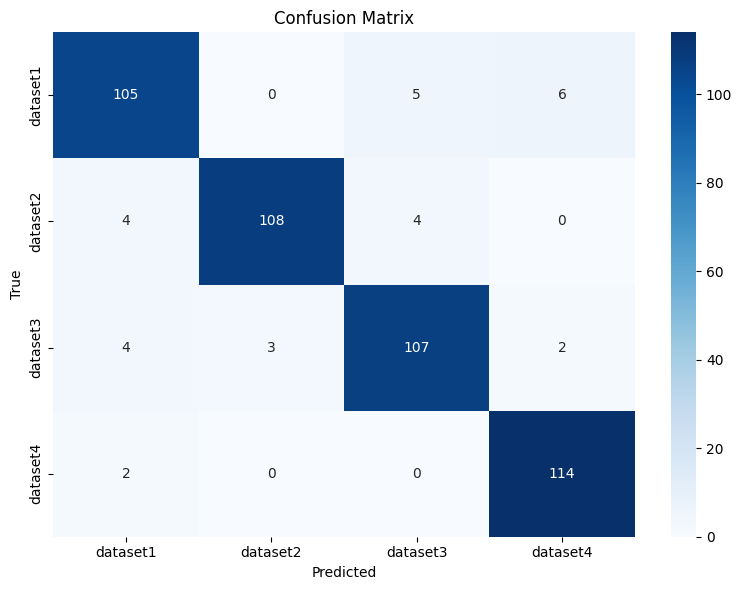

In [35]:
# ============================================================
# STEP 13: EVALUATE THE MODEL
# ============================================================

def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate model on test set"""
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images, mode='standard')
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = 100. * test_correct / test_total

    # Classification report
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns

    class_names = test_dataset.classes
    print(f"🧪 Test Accuracy: {test_acc:.2f}%")
    print("\n📋 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('/content/confusion_matrix.png', dpi=100)
    plt.show()

    return test_acc, all_preds, all_labels

# OPTION 1: Load with weights_only=False (SIMPLER)
print("📥 Loading best model...")
try:
    # First try with weights_only=True (default in PyTorch 2.6+)
    checkpoint = torch.load('/content/best_hybrid_model.pth', weights_only=True)
    print("✅ Loaded with weights_only=True")
except Exception as e:
    print(f"⚠️ Loading with weights_only=True failed: {e}")
    print("🔄 Trying with weights_only=False...")
    # Fall back to weights_only=False
    checkpoint = torch.load('/content/best_hybrid_model.pth', weights_only=False)
    print("✅ Loaded with weights_only=False")

# Load model state
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {checkpoint['epoch']}")
print(f"📊 Best validation accuracy: {checkpoint['val_acc']:.2f}%")

# OPTION 2: Use safe globals approach (ALTERNATIVE - MORE SECURE)
# Uncomment below if Option 1 doesn't work
"""
print("📥 Loading best model with safe globals...")
import torch.serialization
import numpy

# Add safe globals for numpy
torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])

# Load the checkpoint
checkpoint = torch.load('/content/best_hybrid_model.pth', weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {checkpoint['epoch']}")
print(f"📊 Best validation accuracy: {checkpoint['val_acc']:.2f}%")
"""

# Evaluate on test set
print("\n🧪 Evaluating on test set...")
test_acc, predictions, true_labels = evaluate_model(model, test_loader, device=device)

📊 Plotting training history...


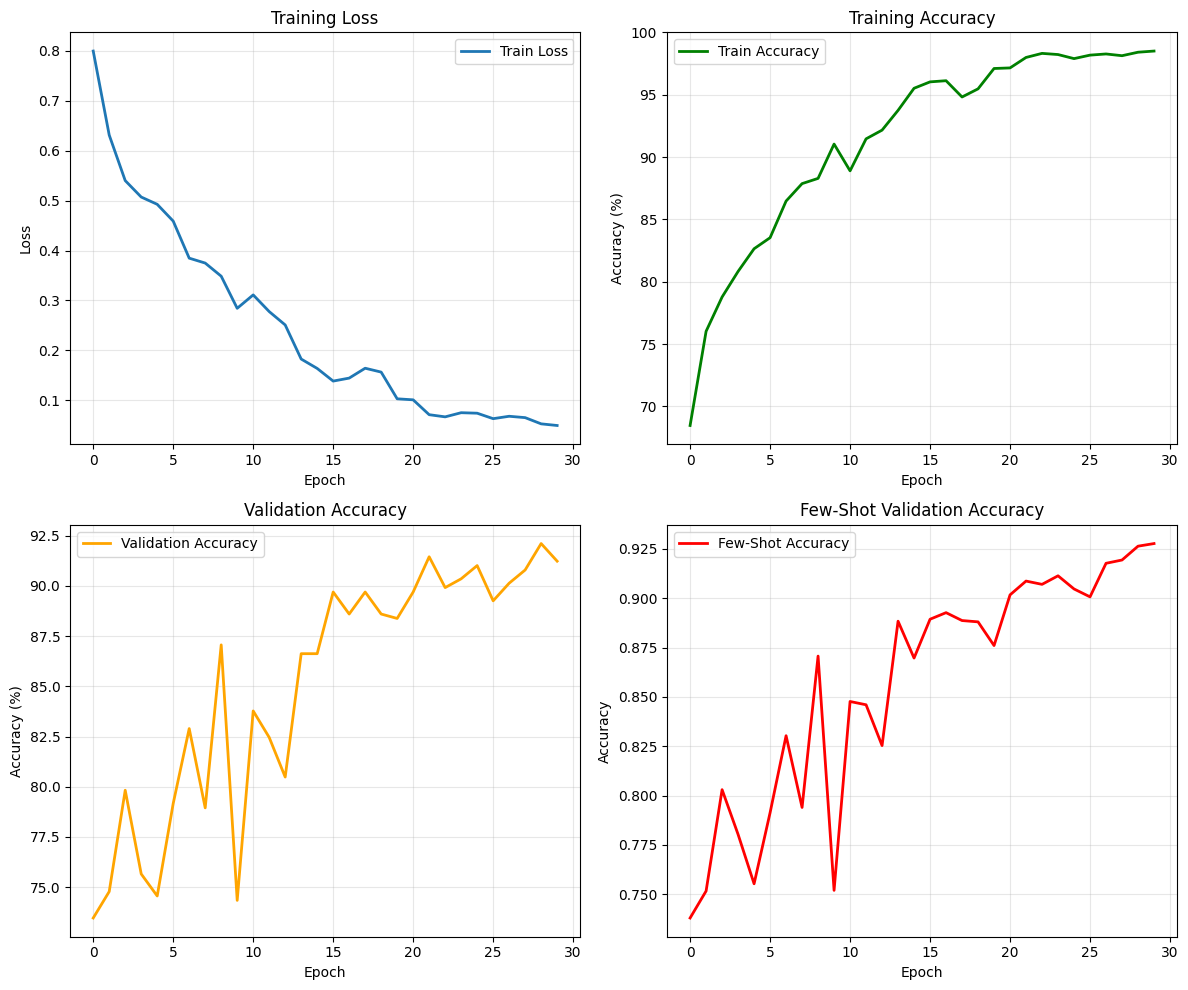

In [36]:
# ============================================================
# STEP 14: VISUALIZE RESULTS
# ============================================================

import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plot training history"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    # Plot 1: Training Loss
    ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Training Accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy', linewidth=2, color='green')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Validation Accuracy
    ax3.plot(history['val_acc'], label='Validation Accuracy', linewidth=2, color='orange')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_title('Validation Accuracy')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Few-Shot Accuracy (if available)
    if history['few_shot_val_acc']:
        ax4.plot(history['few_shot_val_acc'], label='Few-Shot Accuracy', linewidth=2, color='red')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Accuracy')
        ax4.set_title('Few-Shot Validation Accuracy')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Few-Shot Data\nNot Available',
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax4.transAxes,
                fontsize=12)
        ax4.set_title('Few-Shot Validation Accuracy')

    plt.tight_layout()
    plt.savefig('/content/training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot training history
print("📊 Plotting training history...")
plot_training_history(history)

🔬 Visualizing Few-Shot Learning Performance...


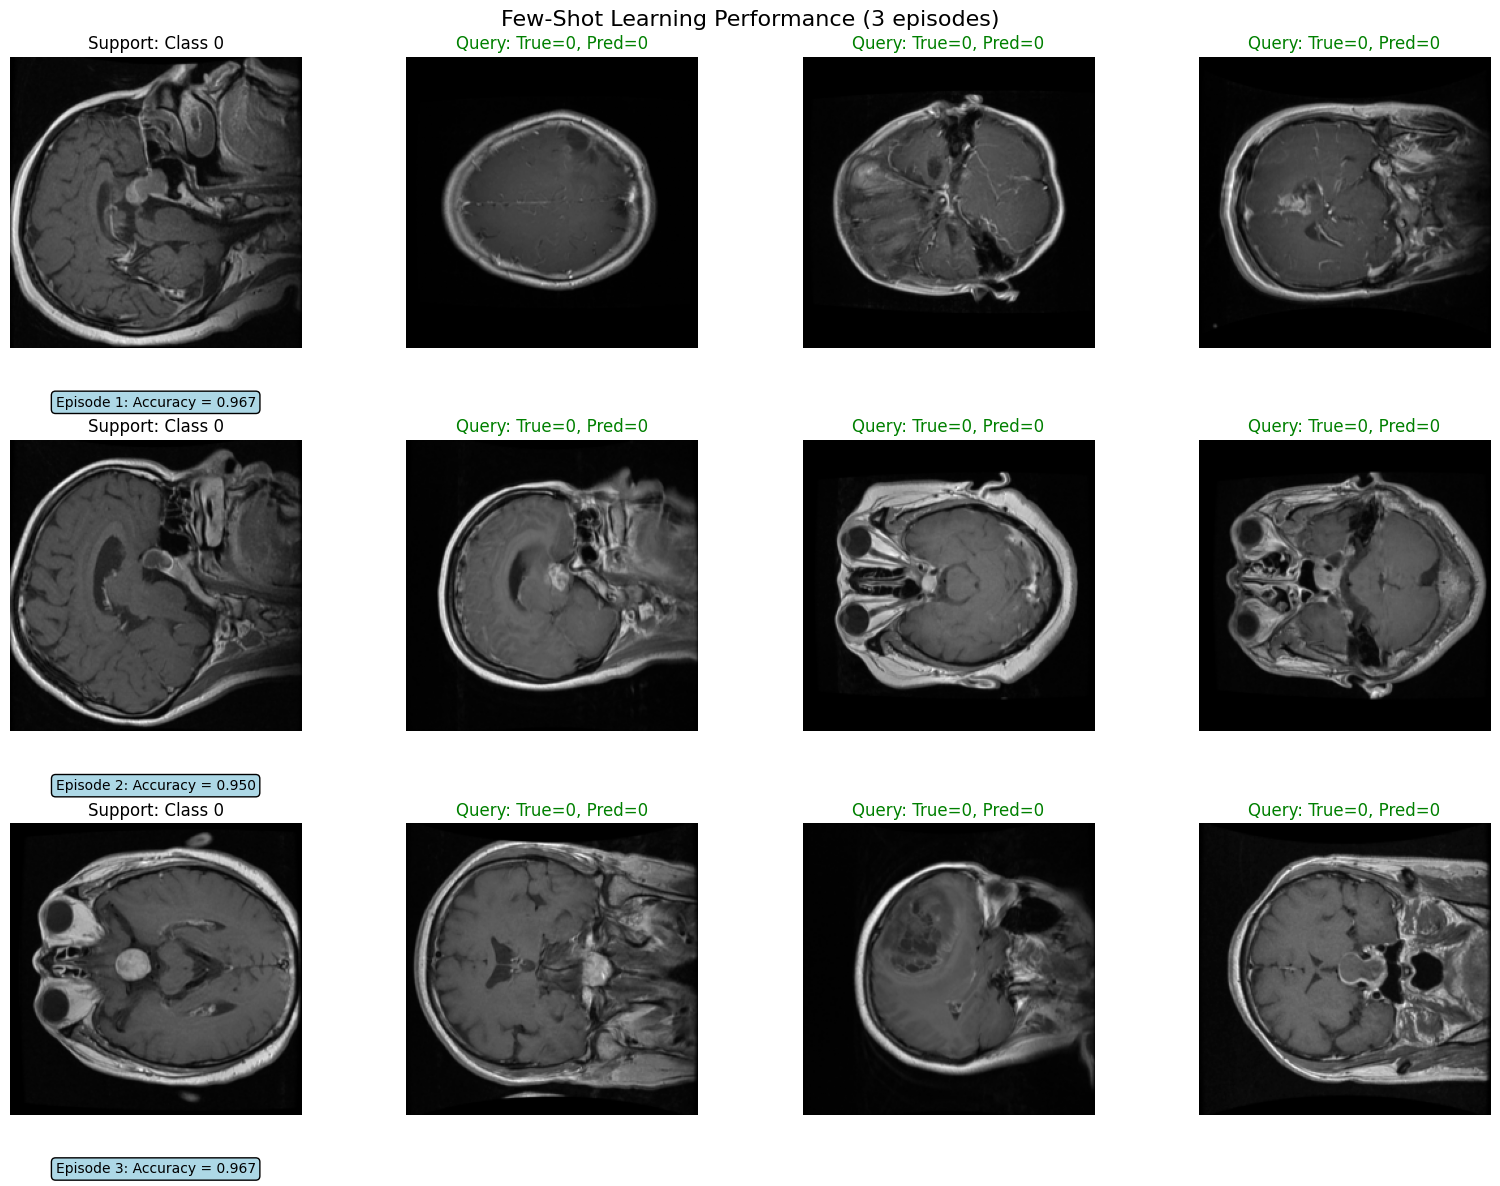


📊 Few-Shot Performance Summary:
  Average Accuracy: 0.961
  Std Deviation: 0.008
  Min Accuracy: 0.950
  Max Accuracy: 0.967


In [38]:
# ============================================================
# STEP 15: FEW-SHOT EVALUATION VISUALIZATION
# ============================================================

def visualize_few_shot_performance(model, few_shot_dataset, num_episodes=5, device='cuda'):
    """Visualize few-shot learning performance - FIXED for list inputs"""
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model.eval()

    fig, axes = plt.subplots(num_episodes, 4, figsize=(16, 4*num_episodes))
    if num_episodes == 1:
        axes = [axes]

    episode_accuracies = []

    for ep_idx in range(num_episodes):
        # Get episode - it returns lists, not tensors
        episode = few_shot_dataset[ep_idx]

        # Convert lists to tensors
        support_images = torch.stack(episode['support_images']).to(device)
        support_labels = torch.tensor(episode['support_labels']).to(device)
        query_images = torch.stack(episode['query_images']).to(device)
        query_labels = torch.tensor(episode['query_labels']).to(device)
        selected_classes = episode['selected_classes']

        with torch.no_grad():
            # Extract embeddings
            support_embeddings = model(support_images, mode='fewshot')
            query_embeddings = model(query_images, mode='fewshot')

            # Compute prototypes
            prototypes = compute_prototypes(support_embeddings, support_labels)

            # Compute predictions
            distances = torch.cdist(query_embeddings, prototypes, p=2)
            logits = -distances
            _, predictions = torch.max(logits, 1)

            # Calculate accuracy
            accuracy = (predictions == query_labels).float().mean().item()
            episode_accuracies.append(accuracy)

        # Visualize support set
        for i in range(min(4, len(support_images))):  # Show first 4 support samples or less
            img = support_images[i].cpu().permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)

            axes[ep_idx][0].imshow(img[:, :, 0], cmap='gray')
            axes[ep_idx][0].set_title(f"Support: Class {support_labels[i].item()}")
            axes[ep_idx][0].axis('off')

        # Visualize query set with predictions
        for i in range(min(3, len(query_images))):  # Show first 3 query samples or less
            img = query_images[i].cpu().permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)

            true_label = query_labels[i].item()
            pred_label = predictions[i].item()
            color = 'green' if true_label == pred_label else 'red'

            axes[ep_idx][i+1].imshow(img[:, :, 0], cmap='gray')
            axes[ep_idx][i+1].set_title(f"Query: True={true_label}, Pred={pred_label}", color=color)
            axes[ep_idx][i+1].axis('off')

        # Fill empty subplots if we don't have enough samples
        for i in range(len(support_images), 4):
            axes[ep_idx][i].axis('off')
        for i in range(len(query_images), 3):
            axes[ep_idx][i+1].axis('off')

        # Add accuracy text
        axes[ep_idx][0].text(0.5, -0.2,
                           f"Episode {ep_idx+1}: Accuracy = {accuracy:.3f}",
                           transform=axes[ep_idx][0].transAxes,
                           horizontalalignment='center',
                           fontsize=10,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

    plt.suptitle(f'Few-Shot Learning Performance ({num_episodes} episodes)', fontsize=16)
    plt.tight_layout()
    plt.savefig('/content/few_shot_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n📊 Few-Shot Performance Summary:")
    print(f"  Average Accuracy: {np.mean(episode_accuracies):.3f}")
    print(f"  Std Deviation: {np.std(episode_accuracies):.3f}")
    print(f"  Min Accuracy: {np.min(episode_accuracies):.3f}")
    print(f"  Max Accuracy: {np.max(episode_accuracies):.3f}")

    return episode_accuracies

# Visualize few-shot performance
print("🔬 Visualizing Few-Shot Learning Performance...")
episode_accuracies = visualize_few_shot_performance(
    model=model,
    few_shot_dataset=few_shot_val_dataset,
    num_episodes=3,
    device=device
)